In [1]:
import pandas as pd
import numpy as np
import tqdm

In [2]:
books = pd.read_csv('./code/data/books.csv')
users = pd.read_csv('./code/data/users.csv')
train_ratings = pd.read_csv('./code/data/train_ratings.csv')
test_ratings = pd.read_csv('./code/data/test_ratings.csv')

In [3]:
print('users shape: ', users.shape)
print('books shape: ', books.shape)
print('train_ratings shape: ', train_ratings.shape)
print('test_ratings shape: ', test_ratings.shape)

users shape:  (68092, 3)
books shape:  (149570, 10)
train_ratings shape:  (306795, 3)
test_ratings shape:  (76699, 3)


## USERS


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   68092 non-null  int64  
 1   location  68092 non-null  object 
 2   age       40259 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.6+ MB


In [5]:
users.isna().sum()/len(users)

user_id     0.000000
location    0.000000
age         0.408756
dtype: float64

### Location

In [6]:
users['location'] = users['location'].str.replace(r'[^0-9a-zA-Z:,]', '', regex=True)
users['location']

0                 timmins,ontario,canada
1                  ottawa,ontario,canada
2                               na,na,na
3                 toronto,ontario,canada
4        victoria,britishcolumbia,canada
                      ...               
68087          danville,pennsylvania,usa
68088           victoria,delaware,canada
68089              irvington,alabama,usa
68090           vancouver,washington,usa
68091          albuquerque,newmexico,usa
Name: location, Length: 68092, dtype: object

In [7]:
users['location_city'] = users['location'].apply(lambda x: x.split(',')[0].strip())
users['location_state'] = users['location'].apply(lambda x: x.split(',')[1].strip())
users['location_country'] = users['location'].apply(lambda x: x.split(',')[2].strip())

users = users.replace('na', np.nan)
users = users.replace('', np.nan)
users

,user_id,location,age,location_city,location_state,location_country
0,8,"timmins,ontario,canada",NaN,timmins,ontario,canada
1,11400,"ottawa,ontario,canada",49.0,ottawa,ontario,canada
2,11676,"na,na,na",NaN,NaN,NaN,NaN
3,67544,"toronto,ontario,canada",30.0,toronto,ontario,canada
4,85526,"victoria,britishcolumbia,canada",36.0,victoria,britishcolumbia,canada
...,...,...,...,...,...,...
68087,278376,"danville,pennsylvania,usa",54.0,danville,pennsylvania,usa
68088,278621,"victoria,delaware,canada",74.0,victoria,delaware,canada
68089,278636,"irvington,alabama,usa",NaN,irvington,alabama,usa
68090,278659,"vancouver,washington,usa",33.0,vancouver,washington,usa


In [8]:
modify_location = users[(users['location_country'].isna())&(users['location_city'].notnull())]['location_city'].values

location_list = []
for location in modify_location:
    try:
        right_location = users[(users['location'].str.contains(location))&(users['location_country'].notnull())]['location'].value_counts().index[0]
        location_list.append(right_location)
    except:
        pass

In [9]:
for location in location_list:
    users.loc[users[users['location_city']==location.split(',')[0]].index,'location_state'] = location.split(',')[1]
    users.loc[users[users['location_city']==location.split(',')[0]].index,'location_country'] = location.split(',')[2]

In [10]:
others = users['location_country'].value_counts()[users['location_country'].value_counts() < 10].index
for country in tqdm.tqdm(others) :
    try :
        users.loc[(users['location_country'] == country), 'location_country'] = 'others'
    except :
        pass

100%|██████████| 215/215 [00:00<00:00, 228.47it/s]


In [11]:
users['location_country'] = users['location_country'].fillna('others')

In [12]:
users['location_country'].nunique()

54

### AGE

In [13]:
users['age']

0         NaN
1        49.0
2         NaN
3        30.0
4        36.0
         ... 
68087    54.0
68088    74.0
68089     NaN
68090    33.0
68091    63.0
Name: age, Length: 68092, dtype: float64

In [14]:
country_age_median = users.groupby('location_country')['age'].median()
users['age'] = users.apply(lambda x : country_age_median[x['location_country']] if pd.isna(x['age']) else x['age'], axis = 1)

global_age_median = users['age'].median()
users['age'].fillna(global_age_median, inplace = True)
print(users['age'].isna().sum())


0


In [15]:
users['age_category'] = users['age'].round(-1).astype(int)
users[['age', 'age_category']]

,age,age_category
0,33.0,30
1,49.0,50
2,34.0,30
3,30.0,30
4,36.0,40
...,...,...
68087,54.0,50
68088,74.0,70
68089,36.0,40
68090,33.0,30


In [16]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           68092 non-null  int64  
 1   location          68092 non-null  object 
 2   age               68092 non-null  float64
 3   location_city     67970 non-null  object 
 4   location_state    66960 non-null  object 
 5   location_country  68092 non-null  object 
 6   age_category      68092 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 3.6+ MB


In [17]:
users.to_csv('./code/data/users_preprocessed.csv', index=False)

## BOOKS


In [18]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149570 entries, 0 to 149569
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   isbn                 149570 non-null  object 
 1   book_title           149570 non-null  object 
 2   book_author          149569 non-null  object 
 3   year_of_publication  149570 non-null  float64
 4   publisher            149570 non-null  object 
 5   img_url              149570 non-null  object 
 6   language             82343 non-null   object 
 7   category             80719 non-null   object 
 8   summary              82343 non-null   object 
 9   img_path             149570 non-null  object 
dtypes: float64(1), object(9)
memory usage: 11.4+ MB


In [19]:
books['isbn']

0         0002005018
1         0060973129
2         0374157065
3         0399135782
4         0425176428
             ...    
149565    067161746X
149566    0767907566
149567    0884159221
149568    0912333022
149569    1569661057
Name: isbn, Length: 149570, dtype: object

In [20]:
isbn_firstdigit = books['isbn'].str[0]

p = pd.DataFrame({'ISBN_1': isbn_firstdigit, 'language': books['language']})
p

,ISBN_1,language
0,0,en
1,0,en
2,0,en
3,0,en
4,0,en
...,...,...
149565,0,en
149566,0,en
149567,0,NaN
149568,0,en


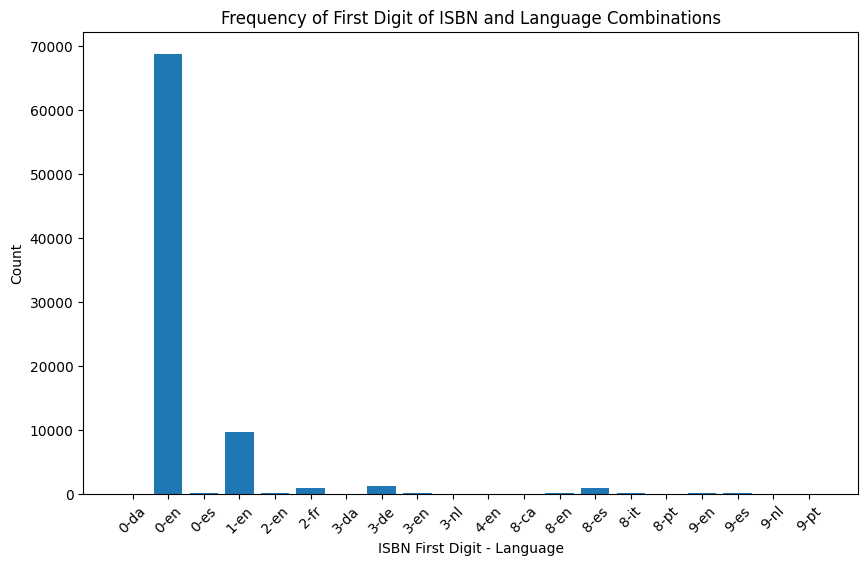

In [21]:
import matplotlib.pyplot as plt

grouped_data = p.groupby(['ISBN_1', 'language']).size().reset_index(name='Count')
grouped_data = grouped_data[grouped_data['Count'] > 10]
grouped_data
plt.figure(figsize=(10, 6))
plt.bar(grouped_data['ISBN_1'] + '-' + grouped_data['language'], grouped_data['Count'])
plt.xlabel('ISBN First Digit - Language')
plt.ylabel('Count')
plt.title('Frequency of First Digit of ISBN and Language Combinations')
plt.xticks(rotation=45)
plt.show()

In [22]:
import seaborn as sns

/tmp/ipykernel_337868/3725330213.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45,horizontalalignment='center')


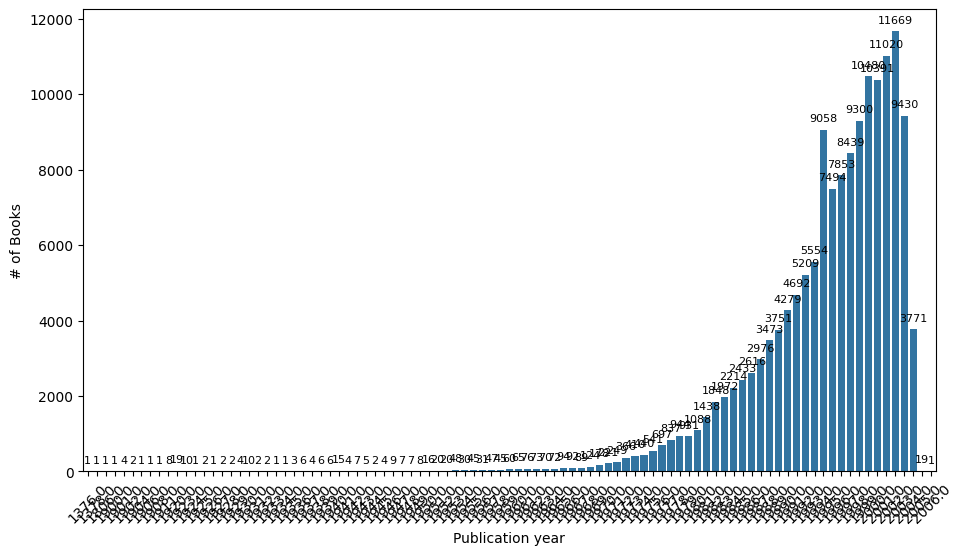

In [23]:
my_dict=(books['year_of_publication'].value_counts()).to_dict()
count= pd.DataFrame(list(my_dict.items()),columns = ['year_of_publication','count'])
f = count.sort_values(by=['count'], ascending = False)
fig=plt.figure(figsize=(11,6))
ax = sns.barplot(y = 'count',x= 'year_of_publication' , data = f)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45,horizontalalignment='center')
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0,8),
                   textcoords='offset points')

plt.xlabel("Publication year", size=10)
plt.ylabel("# of Books", size=10)
plt.show()

In [24]:
def preprocess_year(x) :
    if x < 1970 :
        return 1970
    elif (x >= 1970) and (x < 1980) :
        return 1980
    elif (x >= 1980) and (x < 1990) :
        return 1990
    elif (x >= 1990) and (x < 2000) :
        return 2000
    else :
        return 2010

books['years_category'] = books['year_of_publication'].apply(preprocess_year)
books['years_category'].value_counts()

years_category
2000    72358
2010    46301
1990    23809
1980     5636
1970     1466
Name: count, dtype: int64

/tmp/ipykernel_337868/3861280092.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45,horizontalalignment='center')


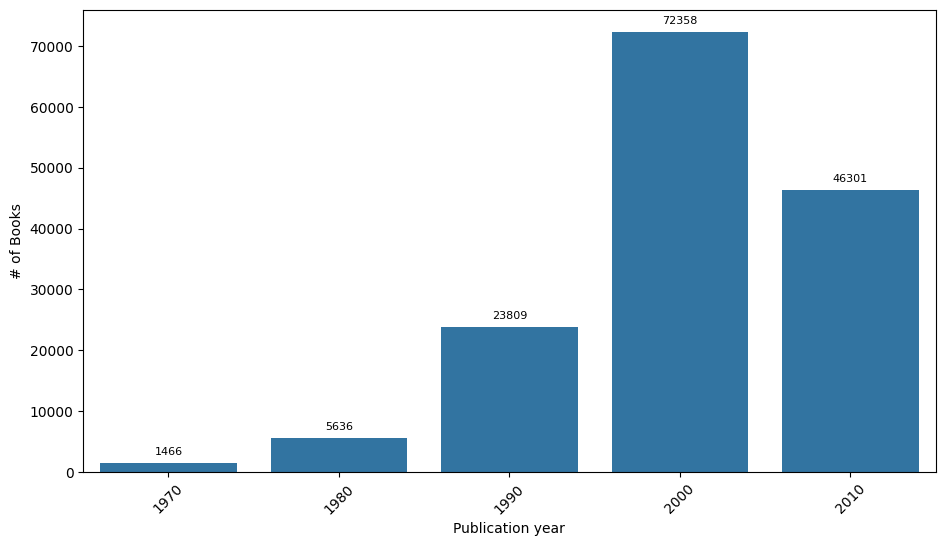

In [25]:
my_dict=(books['years_category'].value_counts()).to_dict()
count= pd.DataFrame(list(my_dict.items()),columns = ['years_category','count'])
f = count.sort_values(by=['count'], ascending = False)
fig=plt.figure(figsize=(11,6))
ax = sns.barplot(y = 'count',x= 'years_category' , data = f)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45,horizontalalignment='center')
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0,8),
                   textcoords='offset points')

plt.xlabel("Publication year", size=10)
plt.ylabel("# of Books", size=10)
plt.show()

In [26]:
publisher_dict=(books['publisher'].value_counts()).to_dict()
publisher_count_df= pd.DataFrame(list(publisher_dict.items()),columns = ['publisher','count'])

publisher_count_df = publisher_count_df.sort_values(by=['count'], ascending = False)
publisher_count_df.head()

,publisher,count
0,Harlequin,3005
1,Ballantine Books,2322
2,Pocket,2274
3,Penguin Books,1943
4,Bantam Books,1938


In [27]:
books['publisher'].nunique() # 수정전 항목 수를 확인합니다.

11571

In [28]:
modify_list = publisher_count_df[publisher_count_df['count']>1].publisher.values

for publisher in modify_list:
    try:
        number = books[books['publisher']==publisher]['isbn'].apply(lambda x: x[:4]).value_counts().index[0]
        right_publisher = books[books['isbn'].apply(lambda x: x[:4])==number]['publisher'].value_counts().index[0]
        books.loc[books[books['isbn'].apply(lambda x: x[:4])==number].index,'publisher'] = right_publisher
    except:
        pass

In [29]:
books['publisher'].nunique() #수정 후 출판사 갯수입니다

1522

In [30]:
books['publisher'].value_counts()

publisher
Pocket                                            7306
Harlequin                                         5268
Bantam Books                                      4815
St. Martin's Press                                4043
Vintage Books USA                                 3822
                                                  ... 
Cornelsen Lernhilfen                                 1
Heinemann Educational Books - Library Division       1
Scottish Academic Press                              1
BZZTÃ´H                                              1
Rosmen                                               1
Name: count, Length: 1522, dtype: int64

In [31]:
region_code = set([code[:1] for code in books['isbn']])

region_lang = dict()

for code in region_code :
    lang = books.loc[books['isbn'].str.startswith(str(code)), 'language']
    mode = lang.mode()[0] if not code == 'B' else 'en' # 'B'로 시작하는 행들은 모두 NaN여서, 'en'으로 대체
    books.loc[(books['isbn'].str.startswith(str(code))) & (books['language'].isna()), 'language'] = mode

books['language'].isna().sum()

0

In [32]:
import re
books.loc[books[books['category'].notnull()].index, 'category'] = books[books['category'].notnull()]['category'].apply(lambda x: re.sub('[\W_]+',' ',x).strip())
books['category'].value_counts()

category
Fiction                     32956
Juvenile Fiction             5804
Biography Autobiography      3320
History                      1925
Religion                     1818
                            ...  
Journalistes Déontologie        1
Babytime resource               1
Mercenary troops                1
Hijacking of aircraft           1
Jewish women                    1
Name: count, Length: 4137, dtype: int64

In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

# 데이터 로딩
books2 = books.copy()

# 결측치 처리
books2.dropna(subset=['book_author', 'book_title'], inplace=True)

# 데이터셋 분할
train_data = books2[books2['category'].notna()]
test_data = books2[books2['category'].isna()]

# 모델 파이프라인 구축
model = make_pipeline(TfidfVectorizer(), MultinomialNB())

# 모델 훈련
model.fit(train_data['book_author'] + " " + train_data['book_title'], train_data['category'])

# 결측 category 예측
predicted_categories = model.predict(test_data['book_author'] + " " + test_data['book_title'])

# 예측 결과 적용
test_data.loc[:, 'predicted_category'] = predicted_categories


/tmp/ipykernel_337868/4229554594.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[:, 'predicted_category'] = predicted_categories


In [35]:
category_counts = test_data['predicted_category'].value_counts()
category_counts

predicted_category
Fiction                    67494
Juvenile Fiction            1154
Computers                     50
Religion                      41
Cooking                       33
Biography Autobiography       30
Health Fitness                18
Business Economics            10
Humor                          9
History                        4
Juvenile Nonfiction            3
Body Mind Spirit               2
Poetry                         1
Family Relationships           1
Name: count, dtype: int64

In [37]:
predicted_categories_df = test_data[['isbn', 'predicted_category']]


In [38]:
books = books.merge(predicted_categories_df, on='isbn', how='left')


In [44]:
books['category'] = books.apply(
    lambda row: row['predicted_category_x'] if pd.isna(row['category']) else row['category'],
    axis=1
)

In [45]:
books.drop('predicted_category_x', axis=1, inplace=True)


In [46]:
books

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path,years_category
0,0002005018,Clara Callan,Richard Bruce Wright,2001.0,Collins,http://images.amazon.com/images/P/0002005018.0...,en,Actresses,"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg,2010
1,0060973129,Decision in Normandy,Carlo D'Este,1991.0,Perennial,http://images.amazon.com/images/P/0060973129.0...,en,1940 1949,"Here, for the first time in paperback, is an o...",images/0060973129.01.THUMBZZZ.jpg,2000
2,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999.0,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,en,Medical,"Describes the great flu epidemic of 1918, an o...",images/0374157065.01.THUMBZZZ.jpg,2000
3,0399135782,The Kitchen God's Wife,Amy Tan,1991.0,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,en,Fiction,A Chinese immigrant who is convinced she is dy...,images/0399135782.01.THUMBZZZ.jpg,2000
4,0425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000.0,Berkley Publishing Group,http://images.amazon.com/images/P/0425176428.0...,en,History,"Essays by respected military historians, inclu...",images/0425176428.01.THUMBZZZ.jpg,2010
...,...,...,...,...,...,...,...,...,...,...,...
149565,067161746X,The Bachelor Home Companion: A Practical Guide...,P.J. O'Rourke,1987.0,Pocket,http://images.amazon.com/images/P/067161746X.0...,en,Humor,A tongue-in-cheek survival guide for single pe...,images/067161746X.01.THUMBZZZ.jpg,1990
149566,0767907566,All Elevations Unknown: An Adventure in the He...,Sam Lightner,2001.0,Broadway Books,http://images.amazon.com/images/P/0767907566.0...,en,Nature,A daring twist on the travel-adventure genre t...,images/0767907566.01.THUMBZZZ.jpg,2010
149567,0884159221,Why stop?: A guide to Texas historical roadsid...,Claude Dooley,1985.0,Bridge Publications,http://images.amazon.com/images/P/0884159221.0...,en,Fiction,NaN,images/0884159221.01.THUMBZZZ.jpg,1990
149568,0912333022,The Are You Being Served? Stories: 'Camping In...,Jeremy Lloyd,1997.0,Pub Group West,http://images.amazon.com/images/P/0912333022.0...,en,Fiction,These hilarious stories by the creator of publ...,images/0912333022.01.THUMBZZZ.jpg,2000


In [47]:
books.to_csv('./code/data/books_preprocessed.csv', index=False)

In [51]:
import random
import torch
import os

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_squared_error
import catboost
from catboost import CatBoostRegressor
print(f'CatBoost Version : {catboost.__version__}')

import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

# 경고 메시지 숨기기
import warnings
warnings.filterwarnings(action = 'ignore')

# Seed 고정
SEED = 42
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    # tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(False) # True
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
seed_everything(SEED)

CatBoost Version : 1.2.2


In [52]:
rating_train = pd.read_csv('./code/data/train_ratings.csv')
rating_test = pd.read_csv('./code/data/test_ratings.csv')
print(books.shape, users.shape, rating_train.shape, rating_test.shape)

(149570, 11) (68092, 7) (306795, 3) (76699, 3)


In [57]:
# country가 결측 / state 결측 X인 경우
states = users[(users['location_state'].notnull()) & (users['location_country'].isna())]['location_state'].values

for state in tqdm.tqdm(states) :
    try :
        country = users.loc[(users['location'].str.contains(state)), 'location_country'].value_counts().index[0]
        users.loc[(users['location'].str.contains(state)) & (users['location_country'].isna()), 'location_country'] = country
    except :
        pass

# country가 결측 / city 결측 X인 경우
cities = users[(users['location_city'].notnull()) & (users['location_country'].isna())]['location_city'].values

for city in tqdm.tqdm(cities) :
    try :
        country = users.loc[(users['location'].str.contains(city)), 'location_country'].value_counts().index[0]
        users.loc[(users['location'].str.contains(city)) & (users['location_country'].isna()), 'location_country'] = country
    except :
        pass

# 각 나라 별로 location의 최빈값으로 대체
countries_list = users['location_country'].value_counts()
for country in tqdm.tqdm(countries_list.index) :
    try :
        new_country = users.loc[(users['location'].str.contains(country)), 'location_country'].value_counts().index[0]
        users.loc[(users['location'].str.contains(country)) & (users['location_country'] == country),
                  'location_country'] = new_country
    except :
        pass

0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 48/48 [00:02<00:00, 17.19it/s]


In [62]:
users.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           68092 non-null  int64  
 1   location          68092 non-null  object 
 2   age               68092 non-null  float64
 3   location_city     67970 non-null  object 
 4   location_state    66960 non-null  object 
 5   location_country  68092 non-null  object 
 6   age_category      68092 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 3.6+ MB


In [60]:
print(users['location_country'].unique())

['canada' 'others' 'usa' 'malaysia' 'newzealand' 'finland' 'unitedkingdom'
 'portugal' 'brazil' 'germany' 'austria' 'australia' 'italy' 'france'
 'netherlands' 'poland' 'iran' 'spain' 'taiwan' 'singapore' 'argentina'
 'romania' 'belgium' 'philippines' 'caymanislands' 'southafrica'
 'switzerland' 'turkey' 'japan' 'china' 'sweden' 'indonesia' 'slovakia'
 'norway' 'southkorea' 'israel' 'egypt' 'denmark' 'czechrepublic'
 'bulgaria' 'slovenia' 'chile' 'hongkong' 'luxembourg' 'iceland' 'hungary'
 'mexico' 'croatia']


In [63]:
# 10개 이하의 country를 others로 변환
others = users['location_country'].value_counts()[users['location_country'].value_counts() < 10].index
for country in tqdm.tqdm(others) :
    try :
        users.loc[(users['location_country'] == country), 'location_country'] = 'others'
    except :
        pass

100%|██████████| 1/1 [00:00<00:00, 183.63it/s]


In [65]:
# 나머지 결측치에 대해서도 others로 변환
users['location_country'] = users['location_country'].fillna('others')
print(users['location_country'].nunique())

47


In [67]:
path = './code/data/'
books_pre = books.copy()
users_pre = users.copy()
train_ratings = pd.read_csv(path + 'train_ratings.csv')
test_ratings = pd.read_csv(path + 'test_ratings.csv')

In [68]:
display(books_pre.info(), users_pre.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149570 entries, 0 to 149569
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   isbn                 149570 non-null  object 
 1   book_title           149570 non-null  object 
 2   book_author          149569 non-null  object 
 3   year_of_publication  149570 non-null  float64
 4   publisher            149570 non-null  object 
 5   img_url              149570 non-null  object 
 6   language             149570 non-null  object 
 7   category             149569 non-null  object 
 8   summary              82343 non-null   object 
 9   img_path             149570 non-null  object 
 10  years_category       149570 non-null  int64  
dtypes: float64(1), int64(1), object(9)
memory usage: 12.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ---

None

None

In [70]:
books_final = books_pre[['isbn', 'language', 'years_category', 'publisher', 'category']]
users_final = users_pre[['user_id', 'location_country', 'age_category']]

In [71]:
train_ratings['index'] = train_ratings.index
train_df = pd.merge(books_final, train_ratings, how = 'left', on = 'isbn').dropna(subset = 'rating')
train_df = pd.merge(users_final, test_df, how = 'left', on = 'user_id').dropna(subset = 'rating')
test_df = train_df.sort_values('index').reset_index(drop = True).drop(columns = 'index')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306795 entries, 0 to 306794
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           306795 non-null  int64  
 1   location_country  306795 non-null  object 
 2   age_category      306795 non-null  int64  
 3   isbn              306795 non-null  object 
 4   language          306795 non-null  object 
 5   years_category    306795 non-null  float64
 6   publisher         306795 non-null  object 
 7   category          306794 non-null  object 
 8   rating            306795 non-null  float64
dtypes: float64(2), int64(2), object(5)
memory usage: 21.1+ MB


In [104]:
test_ratings['index'] = test_ratings.index
test_df = pd.merge(books_final, test_ratings, how = 'left', on = 'isbn').dropna(subset = 'rating')
test_df = pd.merge(users_final, test_df, how = 'left', on = 'user_id').dropna(subset = 'rating')
test_df = test_df.sort_values('index').reset_index(drop = True).drop(columns = 'index')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76699 entries, 0 to 76698
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           76699 non-null  int64  
 1   location_country  76699 non-null  object 
 2   age_category      76699 non-null  int64  
 3   isbn              76699 non-null  object 
 4   language          76699 non-null  object 
 5   years_category    76699 non-null  float64
 6   publisher         76699 non-null  object 
 7   category          76699 non-null  object 
 8   rating            76699 non-null  float64
dtypes: float64(2), int64(2), object(5)
memory usage: 5.3+ MB


In [105]:
train_df['user_id'] = train_df['user_id'].astype('str')
train_df['age_category'] = train_df['age_category'].astype('category')
train_df['years_category'] = train_df['years_category'].astype('int').astype('category')
train_df['rating'] = train_df['rating'].astype('int')
train_df['category'] = train_df['category'].astype('str')

test_df['user_id'] = test_df['user_id'].astype('str')
test_df['age_category'] = test_df['age_category'].astype('category')
test_df['years_category'] = test_df['years_category'].astype('int').astype('category')
test_df['rating'] = test_df['rating'].astype('int')
test_df['category'] = test_df['category'].astype('str')

In [106]:
train_df.head()

,user_id,location_country,age_category,isbn,language,years_category,publisher,category,rating
0,8,canada,30,0002005018,en,2010,Collins,Actresses,4
1,67544,canada,30,0002005018,en,2010,Collins,Actresses,7
2,123629,canada,30,0002005018,en,2010,Collins,Actresses,8
3,200273,canada,30,0002005018,en,2010,Collins,Actresses,8
4,210926,canada,30,0002005018,en,2010,Collins,Actresses,9


In [107]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df.drop(columns = 'rating'), train_df['rating'],
                                                      test_size = 0.2, random_state = SEED)
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

(245436, 8) (245436,) (61359, 8) (61359,)


In [108]:
X_valid['category'][191098]

'Fiction'

In [109]:
from optuna.integration import CatBoostPruningCallback

def objectiveCAT(trial : Trial, X_train, y_train, X_valid, y_valid) :
    param = {
        'learning_rate' : trial.suggest_categorical('learning_rate', [1e-3, 0.01, 0.1, 0.5]),
        'depth' : trial.suggest_int('depth', 1, 15),
        'colsample_bylevel' : trial.suggest_categorical('colsample_bylevel', [1e-3, 0.01, 0.1, 0.5]),
        'boosting_type' : trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
        'bootstrap_type' : trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
    }

    if param['bootstrap_type'] == 'Bayesian':
        param['bagging_temperature'] = trial.suggest_float('bagging_temperature', 0, 10)
    elif param['bootstrap_type'] == 'Bernoulli':
        param['subsample'] = trial.suggest_float('subsample', 0.1, 1)

    model = CatBoostRegressor(**param, loss_function = 'RMSE', eval_metric = 'RMSE',
                              use_best_model = True, random_state = SEED, # task_type = 'GPU', devices = '0'
                              cat_features = [0, 1, 2, 3, 4, 5, 6, 7])
    pruning_callback = CatBoostPruningCallback(trial, 'RMSE', eval_set_index = 1)
    cat_model = model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_valid, y_valid)], verbose = False,
                          early_stopping_rounds = 100, callbacks = [pruning_callback])
    pruning_callback.check_pruned()

    score = mean_squared_error(y_valid, cat_model.predict(X_valid), squared = False)
    return score

In [115]:
# Study Optuna
study = optuna.create_study(direction = 'minimize', sampler = TPESampler(seed = SEED))
study.optimize(lambda trial : objectiveCAT(trial, X_train, y_train, X_valid, y_valid), n_trials = 30)
print(f'Best trial : score {study.best_trial.value}, \n params = {study.best_trial.params} \n')

[I 2023-12-19 06:00:35,016] A new study created in memory with name: no-name-23fd072b-f6cf-42d9-9a87-29ec2cb2d6a5
[I 2023-12-19 06:00:54,257] Trial 0 finished with value: 2.202207712247343 and parameters: {'learning_rate': 0.01, 'depth': 3, 'colsample_bylevel': 0.1, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.8182496720710062}. Best is trial 0 with value: 2.202207712247343.
[I 2023-12-19 06:00:56,688] Trial 1 finished with value: 2.4327865782659766 and parameters: {'learning_rate': 0.1, 'depth': 5, 'colsample_bylevel': 0.001, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 2.202207712247343.
[I 2023-12-19 06:01:07,470] Trial 2 finished with value: 2.4323014754295182 and parameters: {'learning_rate': 0.01, 'depth': 15, 'colsample_bylevel': 0.001, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9183883618709039}. Best is trial 0 with value: 2.202207712247343.
[I 2023-12-19 06:01:19,071] Trial

Best trial : score 2.1598779982287795, 
 params = {'learning_rate': 0.1, 'depth': 10, 'colsample_bylevel': 0.5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'} 



In [119]:
best_params = {'learning_rate': 0.1, 'depth': 10, 'colsample_bylevel': 0.5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}

In [120]:
X_data, y_data = train_df.drop(columns = 'rating'), train_df['rating']

skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = SEED)
valid_rmse = []

# Stratified K-Fold 사용하여 Best Parameter 학습
for fold, (train_idx, valid_idx) in tqdm.tqdm(enumerate(skf.split(X_data, y_data)), total = skf.n_splits) :

    # Train Set과 Valid Set 분할
    X_train, y_train = X_data.iloc[train_idx], y_data.iloc[train_idx]
    X_valid, y_valid = X_data.iloc[valid_idx], y_data.iloc[valid_idx]

    # Best Parameter 학습
    param = best_params # study.best_params

    cat_reg = CatBoostRegressor(**param, loss_function = 'RMSE', eval_metric = 'RMSE',
                                use_best_model = True, random_state = SEED,
                                cat_features = [0, 1, 2, 3, 4, 5, 6, 7])
    cat_reg.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_valid, y_valid)],
                verbose = 300, early_stopping_rounds = 100)

    # 모델 RMSE 출력
    score = mean_squared_error(y_valid, cat_reg.predict(X_valid), squared = False)
    valid_rmse.append(score)
    print(f'Valid Set {fold + 1} 번째 Fold RMSE : {score}')


print(f'모델 RMSE 평균 : {np.array(valid_rmse).mean()} \n')

  0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 2.4048282	test: 2.3882554	test1: 2.3987390	best: 2.3987390 (0)	total: 222ms	remaining: 3m 41s
300:	learn: 2.1610532	test: 1.8368044	test1: 2.1569013	best: 2.1568002 (296)	total: 1m 15s	remaining: 2m 54s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.156612136
bestIteration = 402

Shrink model to first 403 iterations.


 20%|██        | 1/5 [02:11<08:46, 131.53s/it]

Valid Set 1 번째 Fold RMSE : 2.156612136381038
0:	learn: 2.4055183	test: 2.3888046	test1: 2.4003871	best: 2.4003871 (0)	total: 222ms	remaining: 3m 41s
300:	learn: 2.1637640	test: 1.8385227	test1: 2.1581724	best: 2.1580854 (295)	total: 1m 14s	remaining: 2m 53s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.157709198
bestIteration = 412

Shrink model to first 413 iterations.


 40%|████      | 2/5 [04:25<06:38, 132.73s/it]

Valid Set 2 번째 Fold RMSE : 2.1577091981381855
0:	learn: 2.4017994	test: 2.3821121	test1: 2.3972669	best: 2.3972669 (0)	total: 196ms	remaining: 3m 15s
300:	learn: 2.1620198	test: 1.8385704	test1: 2.1665771	best: 2.1665185 (273)	total: 1m 14s	remaining: 2m 53s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.166032577
bestIteration = 413

Shrink model to first 414 iterations.


 60%|██████    | 3/5 [06:38<04:26, 133.05s/it]

Valid Set 3 번째 Fold RMSE : 2.166032576983894
0:	learn: 2.4016065	test: 2.3817772	test1: 2.3959102	best: 2.3959102 (0)	total: 208ms	remaining: 3m 27s
300:	learn: 2.1617487	test: 1.8334521	test1: 2.1637622	best: 2.1637622 (300)	total: 1m 14s	remaining: 2m 52s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.163244692
bestIteration = 360

Shrink model to first 361 iterations.


 80%|████████  | 4/5 [08:36<02:07, 127.13s/it]

Valid Set 4 번째 Fold RMSE : 2.16324469226664
0:	learn: 2.4013900	test: 2.3822762	test1: 2.3957395	best: 2.3957395 (0)	total: 240ms	remaining: 3m 59s
300:	learn: 2.1578123	test: 1.8317115	test1: 2.1600598	best: 2.1600598 (300)	total: 1m 14s	remaining: 2m 52s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.159853904
bestIteration = 310

Shrink model to first 311 iterations.


100%|██████████| 5/5 [10:23<00:00, 124.60s/it]

Valid Set 5 번째 Fold RMSE : 2.1598539041867486
모델 RMSE 평균 : 2.160690501591301 



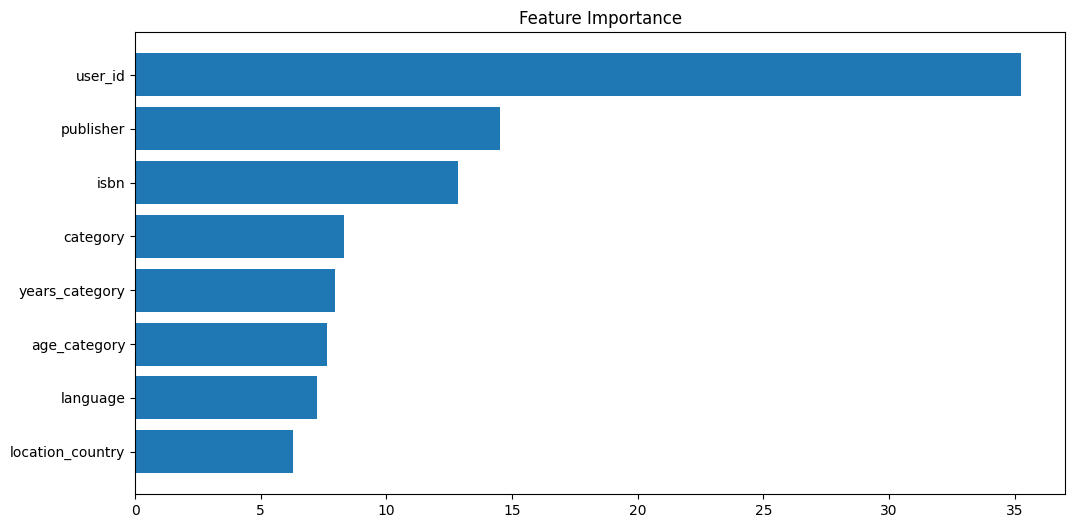

In [121]:
feature_importance = cat_reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize = (12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align = 'center')
plt.yticks(range(len(sorted_idx)), np.array(X_data.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

In [122]:
test_pred = cat_reg.predict(test_df.drop(columns = 'rating'))
test_pred

array([6.5452465 , 6.87217026, 8.18147636, ..., 6.72409848, 5.24325266,
       6.45450671])

In [124]:
test_df['rating'] = test_pred
submit = test_df[['user_id', 'isbn', 'rating']]
submit.to_csv('./code/submit/Catboost_Optuna.csv', index = False)